# 基于多种回归方法的Kaggle房价预测
## 1.问题背景与分析
Kaggle房价预测：[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

房价与我们的生活息息相关，房价的波动牵动着无数购房者的心。如果能够预测房价的走势，可以有效地帮助购买者做出合理的决策。本项目中，我们选择kaggle竞赛中的爱荷华州艾姆斯住宅数据集，数据集中有 79 个变量几乎描述了爱荷华州艾姆斯 (Ames, Iowa) 住宅的方方面面。我们将对数据集建模分析，并对房价进行预测。

影响房价的因素有很多，我们将进行数据可视化来分析各个因素对房价的影响，使用特征工程选择最相关的因素，利用多个机器学习算法（如决策树回归、xgboost等 ）构建房价回归模型，并对比分析预测结果。
### 导入相关包

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 读取数据集

In [53]:
data=pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
data.shape

(1460, 81)

### 数据缺失处理

In [54]:
for i in data.columns[1:]:
    if data[i].isnull().sum()>0:
        print(i,data[i].isnull().sum())

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


#### 可以看出Alley/PoolQC/Fence/MiscFeature属性缺失较多条目，可以直接进行删除
#### 删除ID属性以及缺失30%以上数据的属性

In [55]:
Deldata= data[[column for column in data if data[column].count()/len(data)>=0.3]]
del Deldata['Id']
print("删除的属性", end=" ")
for c in data.columns:
    if c not in Deldata.columns:
        print(c, end=", ")
print('\n')
data = Deldata

删除的属性 Id, Alley, PoolQC, Fence, MiscFeature, 



In [56]:
data.shape

(1460, 76)

## 2.数据可视化探索

### 数据集属性

- SalePrice-该房产的售价。这是我们要预测的目标变量。  
- MSSubClass：建筑分类  
- MSZoning：常规分区分类  
- LotFrontage：街道的线性尺寸 
- LotArea：以平方英尺为单位的地块大小 
- Street：街道的类型  
- Alley：胡同的类型  
- LotShape：房产的一般形状  
- LandContour：房产的平坦度  
- Utilities：可用的公共设施类型  
- LotConfig：地块配置  
- LandSlope：房产的坡度  
- Neighborhood：埃姆斯市区范围内的地理位置  
- Condition1：接近主干道或铁路  
- Condition2：接近主要道路或铁路（如果有）  
- BldgType：住宅类型  
- HouseStyle：住宅风格  
- OverallQual：总体材料和加工质量  
- OverallCond：总体状况的评价  
- YearBuilt：原始施工日期  
- YearRemodAdd：改型日期  
- RoofStyle：屋顶类型  
- RoofMatl：屋顶材料  
- Exterior1st：房屋外墙  
- Exterior2nd：房屋的外墙覆盖物（如果使用一种以上的材料）  
- MasVnrType：砖石饰面类型  
- MasVnrArea：砌面贴面面积（平方英尺）  
- ExterQual：外部材料质量  
- ExterCond：外部材料的当前状态  
- Foundation：基金会的类型  
- BsmtQual：地下室的高度  
- BsmtCond：地下室的一般状况  
- BsmtExposure：罢工或花园水平的地下室墙壁  
- BsmtFinType1：地下室成品区域的质量  
- BsmtFinSF1：1型成品的尺寸（平方英尺）
- BsmtFinType2：第二个完成区域的质量（如果存在）  
- BsmtFinSF2：2型成品尺寸（平方英尺） 
- BsmtUnfSF：未完成的地下室面积（平方英尺 ） 
- TotalBsmtSF：地下室总平方英尺  
- Heating：供热方式  
- HeatingQC：供热质量和条件  
- CentralAir：中央空调  
- Electrical：电气系统  
- 1stFlrSF：一楼面积 
- 2ndFlrSF：二楼面积  
- LowQualFinSF：低质量完成面积（所有楼层）  
- GrLivArea：地面（地面）以上居住面积  
- BsmtFullBath：地下室全浴室  
- BsmtHalfBath：地下室半浴室  
- FullBath：地上全浴室  
- HalfBath：地上半浴室 
- Bedroom：地下室以上的卧室数量  
- Kitchen：厨房数量  
- KitchenQual：厨房质量  
- TotRmsAbvGrd：上等客房总数（不包括浴室）  
- Functional：家庭功能等级  
- Fireplaces：壁炉数量  
- FireplaceQu：壁炉质量  
- GarageType：车库位置  
- GarageYrBlt：车库建成年份 
- GarageFinish：车库的内部装饰  
- GarageCars：车库中车库的大小  
- GarageArea：车库的大小（平方英尺）  
- GarageQual：车库质量  
- GarageCond：车库条件  
- PavedDrive：铺装的车道  
- WoodDeckSF：木制地板面积（平方英尺）  
- OpenPorchSF：开放式阳台面积（平方英尺）  
- EnclosedPorch：封闭的走廊面积（以平方英尺为单位）  
- 3SsnPorch：三季走廊面积（以平方英尺为单位）  
- ScreenPorch：纱窗走廊面积（以平方英尺为单位）  
- PoolArea：游泳池面积  
- PoolQC：泳池质量  
- Fence：围栏质量  
- MiscFeature：未包括在其他类别中的各方面特点 
- MiscVal：各方面特点的价值  
- MoSold：已售月份 
- YrSold：已售年份  
- SaleType：销售类型  
- SaleCondition：销售条件  

In [17]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### 2.1数值数据分析

#### 五数概括 

In [57]:
numCol='LotFrontage/LotArea/MasVnrArea/BsmtFinSF1/BsmtFinSF2/BsmtUnfSF/TotalBsmtSF/1stFlrSF/2ndFlrSF/LowQualFinSF/GrLivArea/BsmtFullBath/BsmtHalfBath/FullBath/HalfBath/BedroomAbvGr/KitchenAbvGr/TotRmsAbvGrd/Fireplaces/GarageCars/GarageArea/WoodDeckSF/OpenPorchSF/EnclosedPorch/3SsnPorch/ScreenPorch/PoolArea/MiscVal/MoSold/YrSold/YearBuilt/YearRemodAdd/GarageYrBlt/SalePrice'
num=numCol.split('/')
numFeature=data[num]
numFeature.shape

(1460, 34)

In [19]:
# numFeature=data.select_dtypes(include =[np.number])
# numFeature

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,366,0,112,0,0,0,0,4,2010,142125


In [23]:
data[numFeature.columns].describe().loc['min':'max'].T

,min,25%,50%,75%,max
LotFrontage,21.0,59.00,69.0,80.00,313.0
LotArea,1300.0,7553.50,9478.5,11601.50,215245.0
MasVnrArea,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,334.0,882.00,1087.0,1391.25,4692.0
2ndFlrSF,0.0,0.00,0.0,728.00,2065.0
LowQualFinSF,0.0,0.00,0.0,0.00,572.0


#### 绘制盒图

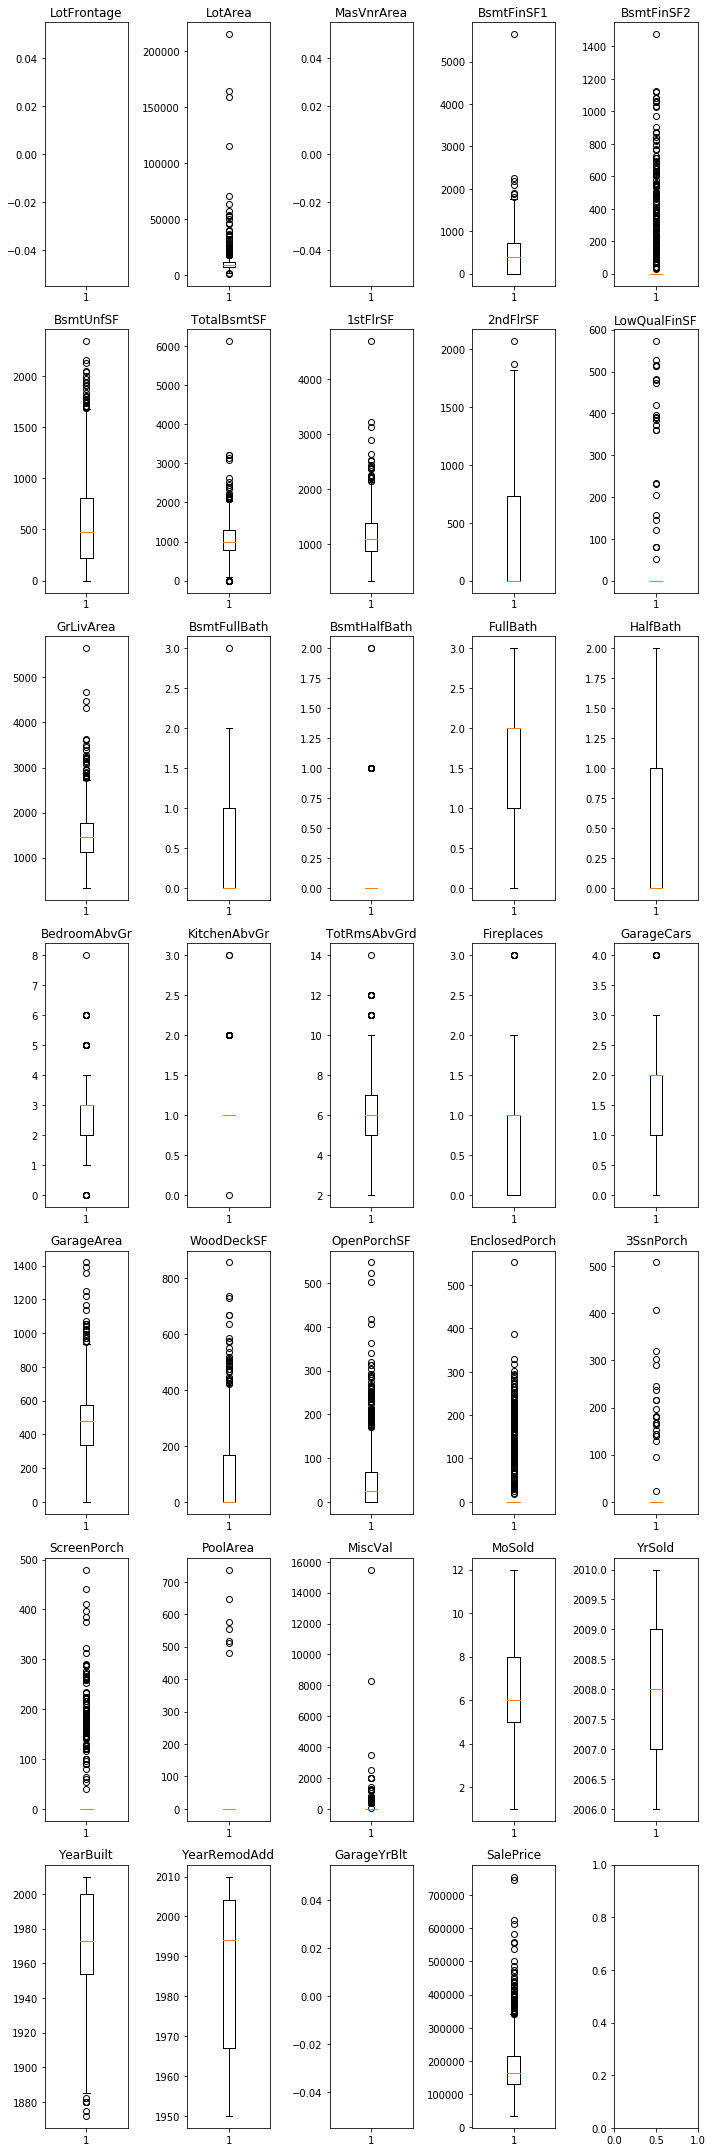

In [24]:
fig, axes = plt.subplots(7, 5, figsize=(10, 30))
#, figsize=(15, 20)
for i,col in enumerate(numFeature.columns):
    axes[i//5, i%5].boxplot(data[col].values)
    axes[i//5, i%5].set_title(col)
fig.tight_layout()

#### 绘制数值属性的直方图分布

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025ACF2AD1C8>,
      dtype=object)

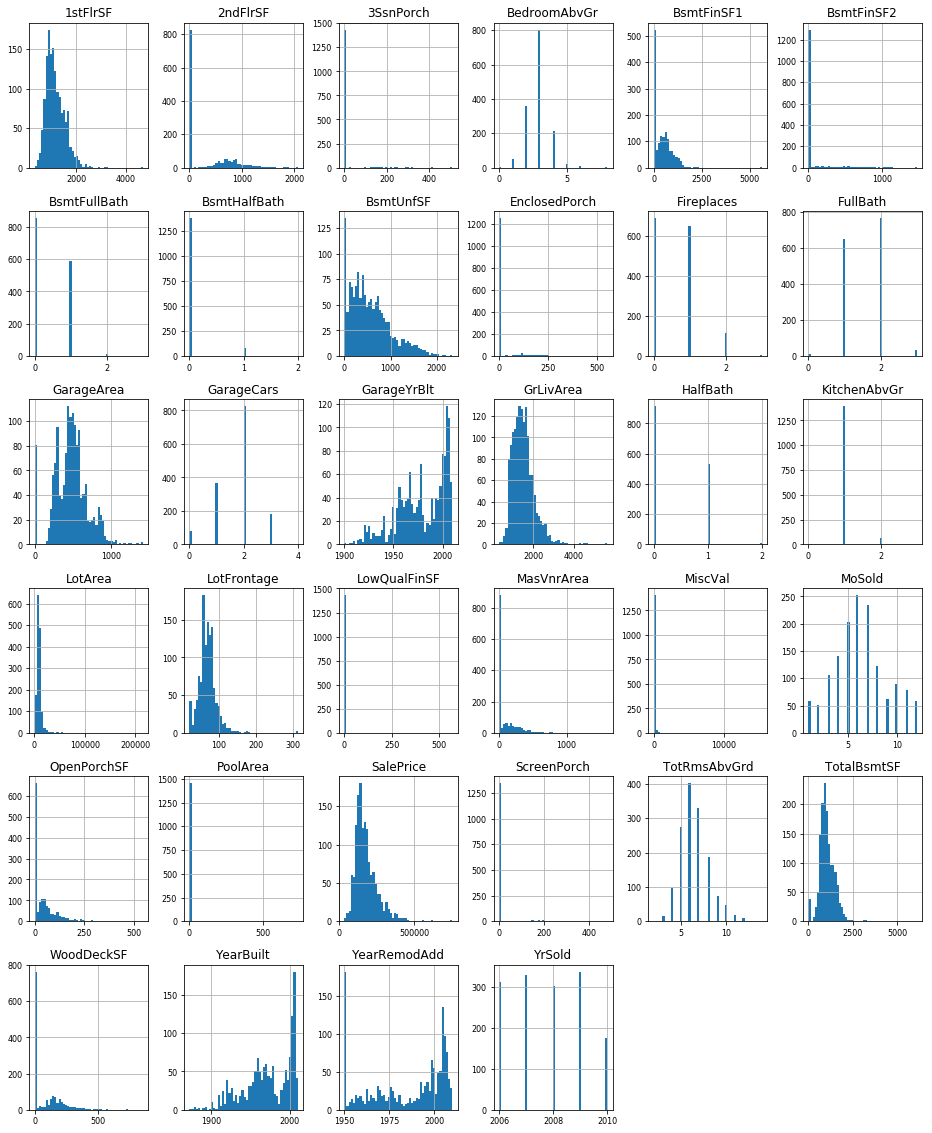

In [25]:
numFeature.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### 2.2标称数据
#### 绘制标称属性的频率直方图

In [58]:
Nominal='MSSubClass/MSZoning/Street/LotShape/LandContour/Utilities/LotConfig/LandSlope/Neighborhood/Condition1/Condition2/BldgType/HouseStyle/OverallQual/OverallCond/RoofStyle/RoofMatl/Exterior1st/Exterior2nd/MasVnrType/ExterQual/ExterCond/Foundation/BsmtQual/BsmtCond/BsmtExposure/BsmtFinType1/BsmtFinType2/Heating/HeatingQC/CentralAir/Electrical/KitchenQual/Functional/FireplaceQu/GarageType/GarageFinish/GarageQual/GarageCond/PavedDrive/SaleType/SaleCondition'
NomFeature=data[Nominal.split('/')]
NomFeature.shape

(1460, 42)

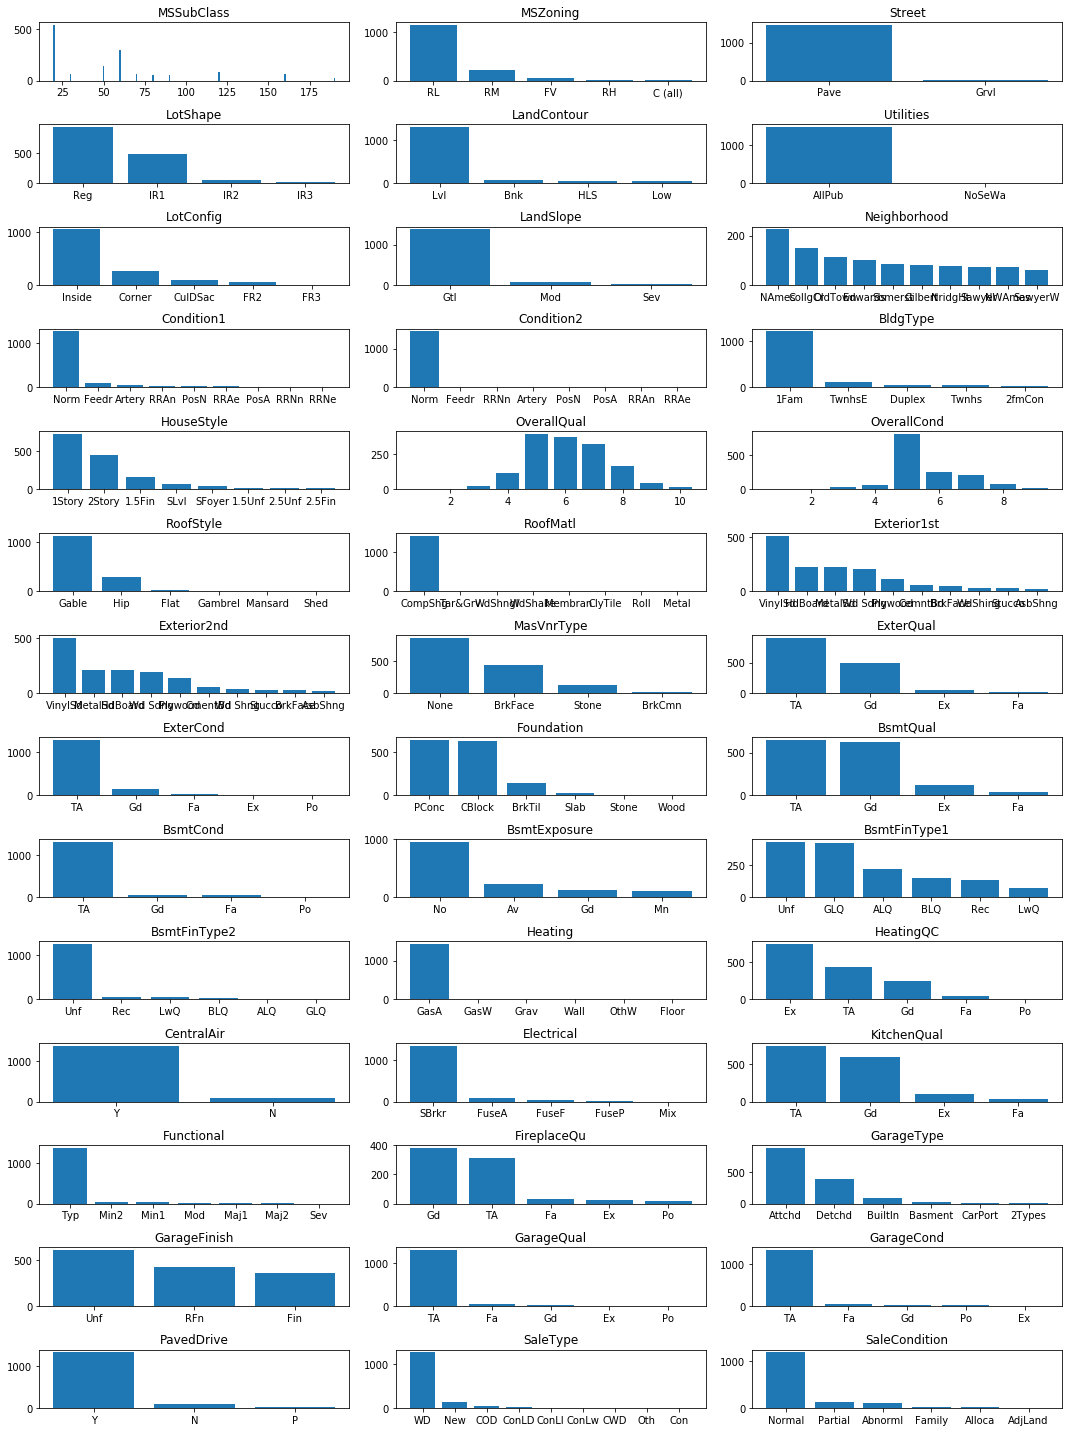

In [27]:
fig, axes = plt.subplots(14, 3, figsize=(15, 20))
#, figsize=(15, 20)
for i,col in enumerate(NomFeature.columns):
    c = data[col].value_counts()[:10]
    axes[i//3, i%3].bar(c.index,c.values)
    axes[i//3, i%3].set_title(col)
fig.tight_layout()

## 3.特征选择

### 3.1绘制heatmap，查看数值属性与salePrice的相关性

In [30]:
correlation = numFeature.corr()

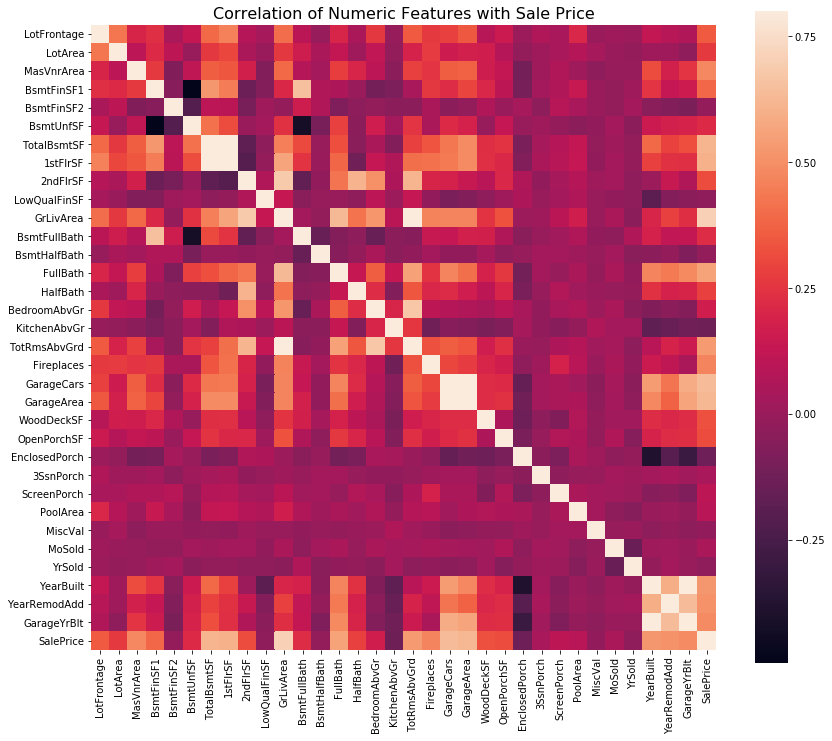

In [31]:
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

 #### 'TotalBsmtSF'、'1stFlrSF'、 'GarageCars'、 'GarageAreas'、'GrLibArea'变量与SalePrice的相关性较强  
 #### 进一步对前十个相关性较强的数值属性进行挖掘

Index(['SalePrice', 'OverallQual', 'Foundation', 'CentralAir', 'Electrical',
       'PavedDrive', 'RoofStyle', 'SaleCondition', 'Neighborhood',
       'HouseStyle'],
      dtype='object')


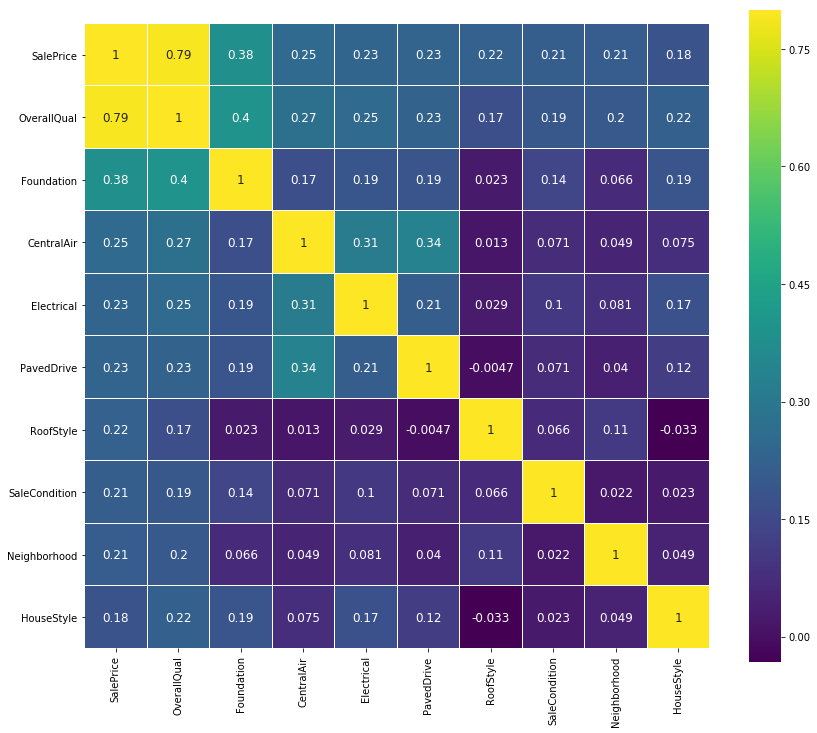

In [68]:
k= 10
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(data[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

#### 可以看出，'TotalBsmtSF'与'1stFlrSF'、 'GarageCars'与'GarageAreas'相关性较强，故在选择特征时，可以只使用TotalBsmtSF和GarageCars
#### 所以数值属性特征可以选择
- 'GrLivArea'
- 'GarageCars'
- 'TotalBsmtSF'
- 'FullBath'
- 'TotRmsAbvGrd'
- 'YearBuilt'
- 'YearRemodAdd'

### 将标称属性转变成数值离散形式

In [62]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
for i in NomFeature.columns:
    if data[i].dtype=='O':
        data[i]=number.fit_transform(data[i].astype('str'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null int32
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null int32
LotShape         1460 non-null int32
LandContour      1460 non-null int32
Utilities        1460 non-null int32
LotConfig        1460 non-null int32
LandSlope        1460 non-null int32
Neighborhood     1460 non-null int32
Condition1       1460 non-null int32
Condition2       1460 non-null int32
BldgType         1460 non-null int32
HouseStyle       1460 non-null int32
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null int32
RoofMatl         1460 non-null int32
Exterior1st      1460 non-null int32
Exterior2nd      1460 non-null int32
MasVnrType       1460 non-null int32
Mas

In [66]:
Corr='MSSubClass/MSZoning/Street/LotShape/LandContour/Utilities/LotConfig/LandSlope/Neighborhood/Condition1/Condition2/BldgType/HouseStyle/OverallQual/OverallCond/RoofStyle/RoofMatl/Exterior1st/Exterior2nd/MasVnrType/ExterQual/ExterCond/Foundation/BsmtQual/BsmtCond/BsmtExposure/BsmtFinType1/BsmtFinType2/Heating/HeatingQC/CentralAir/Electrical/KitchenQual/Functional/FireplaceQu/GarageType/GarageFinish/GarageQual/GarageCond/PavedDrive/SaleType/SaleCondition/SalePrice'
NomFeatures=data[Corr.split('/')]
correlation = NomFeatures.corr()

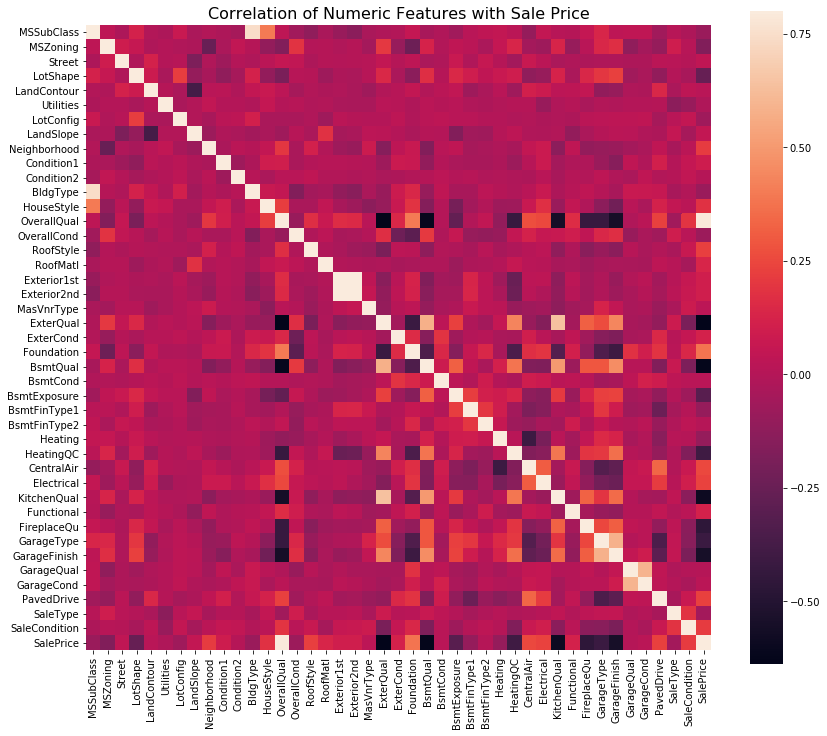

In [67]:
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

#### 可以看出，标称属性中与salePrice相关性较强的有OveralQual

Index(['SalePrice', 'OverallQual', 'Foundation', 'CentralAir', 'Electrical',
       'PavedDrive', 'RoofStyle', 'SaleCondition', 'Neighborhood',
       'HouseStyle'],
      dtype='object')


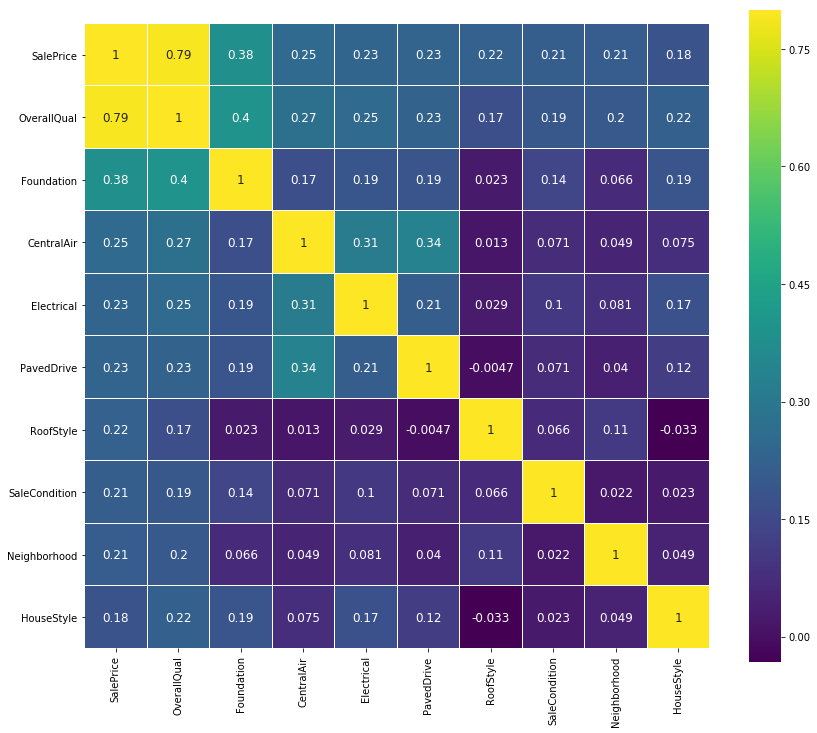

In [69]:
k= 10
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(data[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

#### 标称属性的特征选择为：
- 'OverallQual'
- 'Foundation'
- 'CentralAir'
- 'Electrical',
- 'PavedDrive'
- 'RoofStyle'
- 'SaleCondition'
- 'Neighborhood',
- 'HouseStyle'